In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import treeswift
import math

In [273]:
%load_ext autoreload
%autoreload 2
    
import helpers.utils
from helpers.utils import build_summary_df
from helpers.utils import plot_genotype_confidence
from helpers.utils import clustermap_genos
from helpers.utils import distdict_to_df, leaf_pairs, get_geno_dict
from helpers.utils import im_ehd, empirical_site_dists, ehd, sm_ehd, pair_metrics
from helpers.utils import plot_concordance_scatterplot, plot_concordance_distribution
from helpers.utils import plot_state_counts, report_genotype_call_stats, save_df_to_pdf
from helpers.utils import plot_correlation, plot_bl_variance, add_internal_labels, branch_table
from helpers.utils import plot_tree_3d, edge_ratio_table, plot_genotypecall_summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.insert(0, "/Users/gc3045/git/fast-laml/scripts") 
import euclidean_solver as es

In [4]:
# pip install legacy-cgi

In [5]:
inputs_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/"
plotdir = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots/"
lamlpro_col2_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/runjobs/outputs_baseMemoir_colony2/fastlaml_baseMemoir.colony2.published"
lamlpro_col5_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/runjobs/outputs_baseMemoir_colony2/fastlaml_baseMemoir.colony5.stepwise_addition_03"

In [6]:
bm_input_geno = inputs_basename + "baseMemoir_colony2_baseMemoir_genotypes.csv"
lp_map_geno = lamlpro_col2_basename + "_posterior_argmax.csv"

bm_treefile = inputs_basename + "trees/baseMemoir.colony2.published.nwk"
lp_treefile = lamlpro_col2_basename + "_tree.newick"

centroids_fname = inputs_basename + "colony2_centroids.txt"
# bm_c5_input_geno = inputs_basename + "baseMemoir_colony5_baseMemoir_genotypes.csv
# lp_c5_map_geno = lamlpro_col5_basename + "_posterior_argmax.csv"

In [7]:
bm_input_geno_df = pd.read_csv(bm_input_geno)
lp_map_geno_df = pd.read_csv(lp_map_geno, skiprows=2, index_col=0)
centroids_df = pd.read_csv(centroids_fname, sep="\t", header=None, index_col=0)

In [8]:
bm_tree = treeswift.read_tree_newick(bm_treefile)
lp_tree = treeswift.read_tree_newick(lp_treefile)

#### Genotype plausibility

In [9]:
summary_df = build_summary_df(bm_input_geno_df, lp_map_geno_df)

[build_summary_df] merged rows: 8322 | LP matches: 8322 | both_present: 8322 | agree: 6773 (0.8138668589281423) | disagree_true: 1549 (0.18613314107185772)


'/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_genotype_probabilities.pdf'

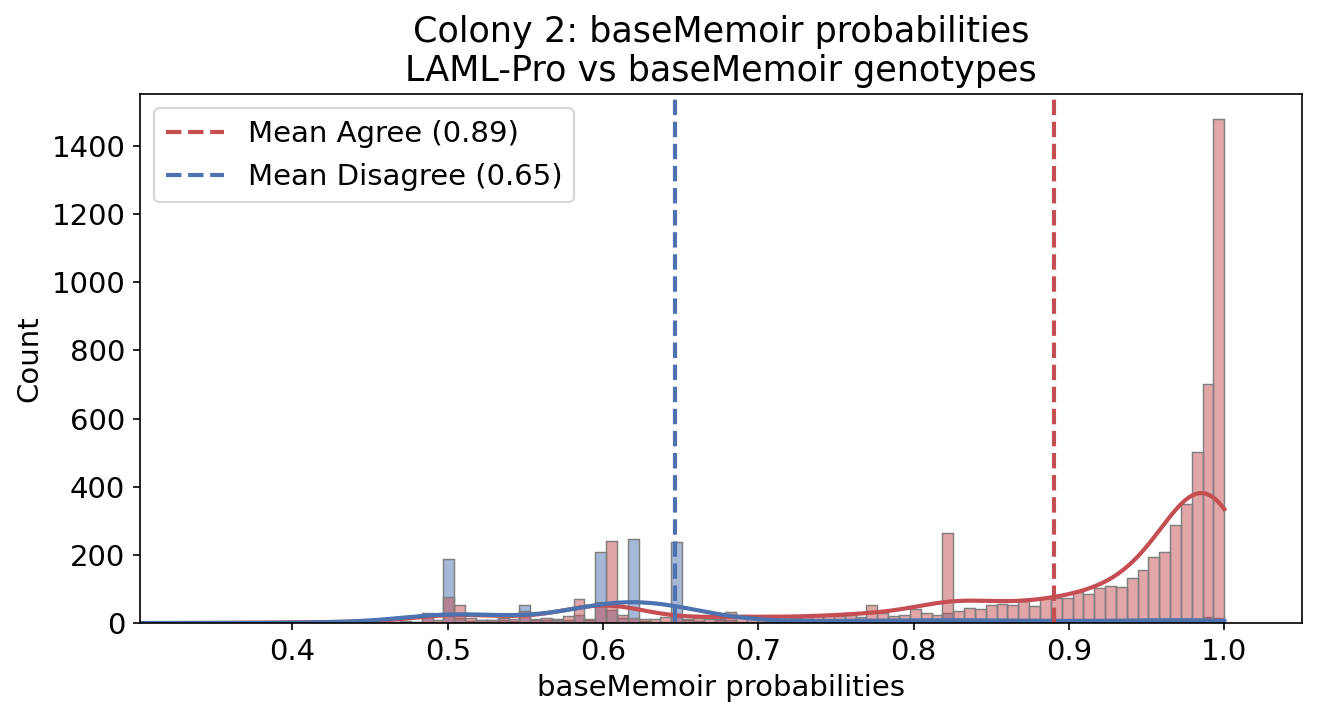

In [10]:
plot_genotype_confidence(summary_df, title="Colony 2: baseMemoir probabilities\nLAML-Pro vs baseMemoir genotypes",
                         outfile=f"{plotdir}/colony2_genotype_probabilities.pdf",
                         bins=100)

In [11]:
bm_geno_df = bm_input_geno_df[['cell_name', 'target_site', 'bM_geno']]
bm_geno_df = bm_geno_df.pivot(
    index="cell_name", 
    columns="target_site", 
    values="bM_geno"
).sort_index(axis=1).fillna(-1)

In [12]:
lp_map_geno_df.columns = bm_geno_df.columns
lp_map_geno_df = lp_map_geno_df.loc[[x for x in lp_map_geno_df.index if not x.startswith('internal')], :]
lp_map_geno_df.index = [int(x) for x in lp_map_geno_df.index]
bm_geno_df.index = [int(x) for x in bm_geno_df.index]

In [13]:
(lp_map_geno_df == -1).sum().sum()

np.int64(240)

/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


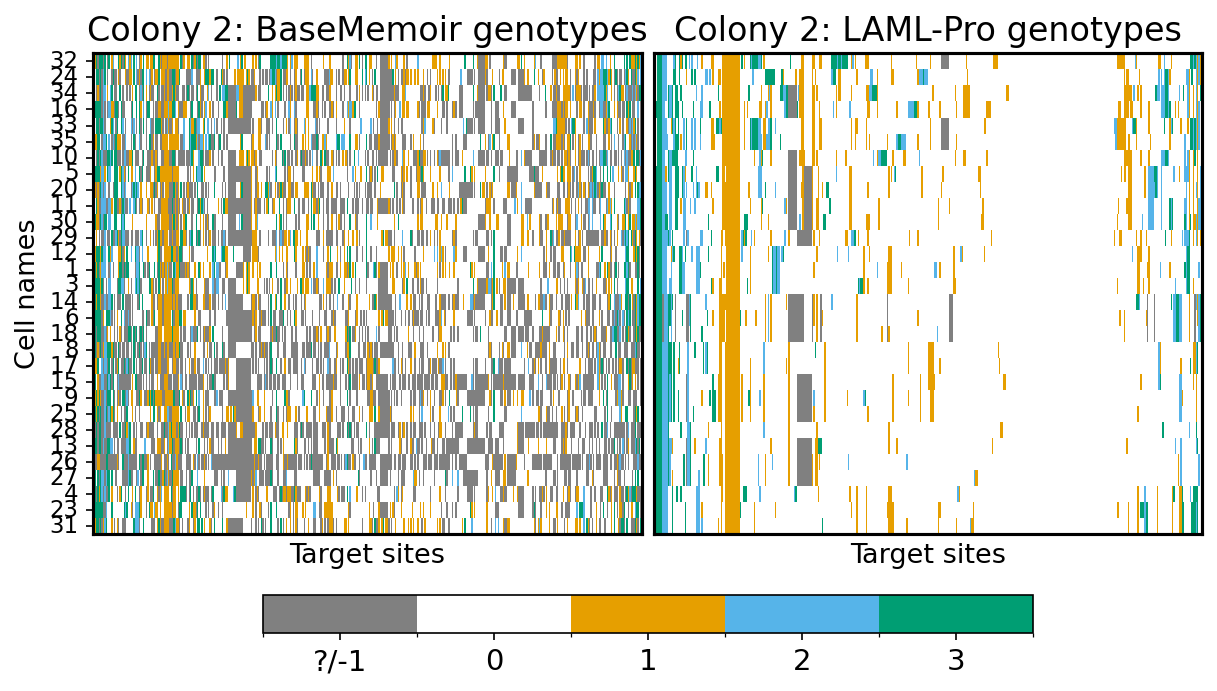

In [307]:
cg = clustermap_genos(bm_geno_df, lp_map_geno_df, metric='euclidean', method='centroid', title="Colony 2")

In [73]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

def clustermap_column_order(df, metric="hamming", method="complete"):
    D = pdist(df.T, metric=metric)      # distances between columns (target sites)
    Z = linkage(D, method=method)       # hierarchical clustering
    idx = leaves_list(Z)                # column order
    return df.columns.to_numpy()[idx].tolist()

target_site_order = clustermap_column_order(bm_geno_df, metric="hamming", method="complete")


/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


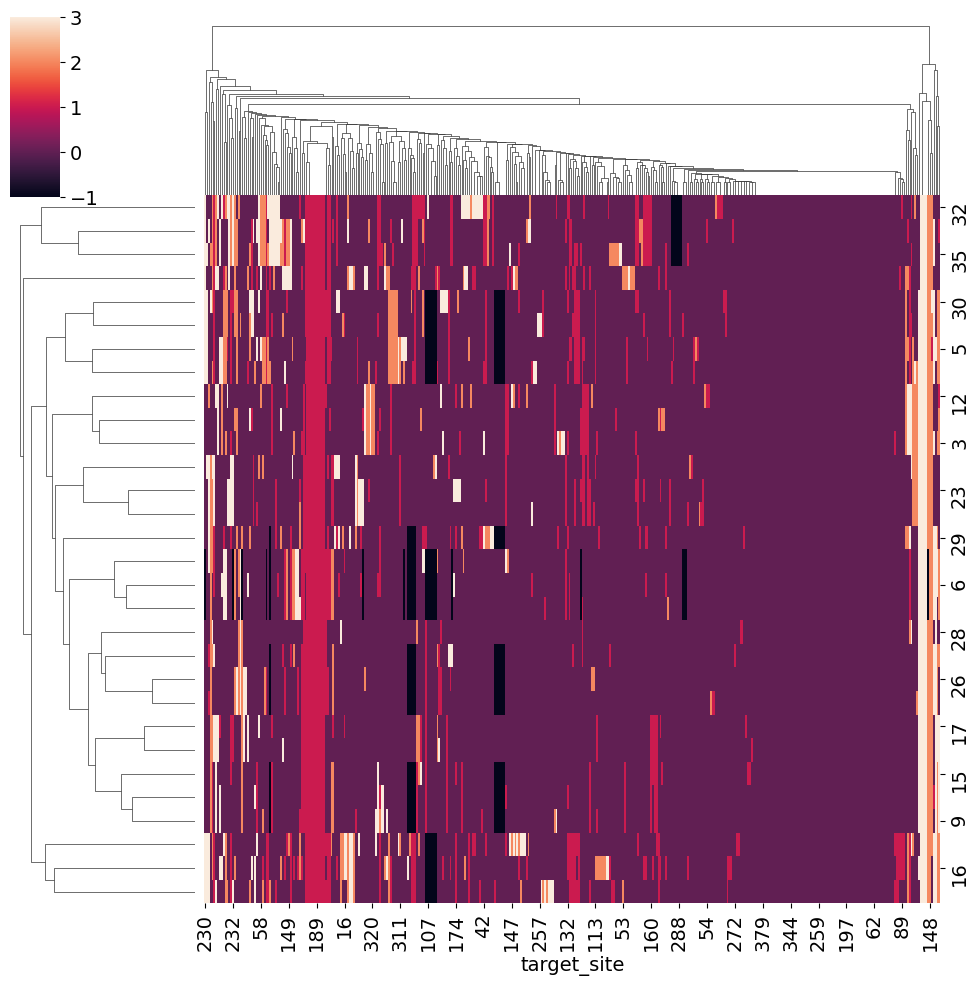

In [97]:
cg = sns.clustermap(lp_map_geno_df, col_cluster=True)
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
lp_ord = lp_map_geno_df.iloc[row_order, :].iloc[:, col_order]
bm_ord = bm_geno_df.iloc[row_order, :].iloc[:, col_order]

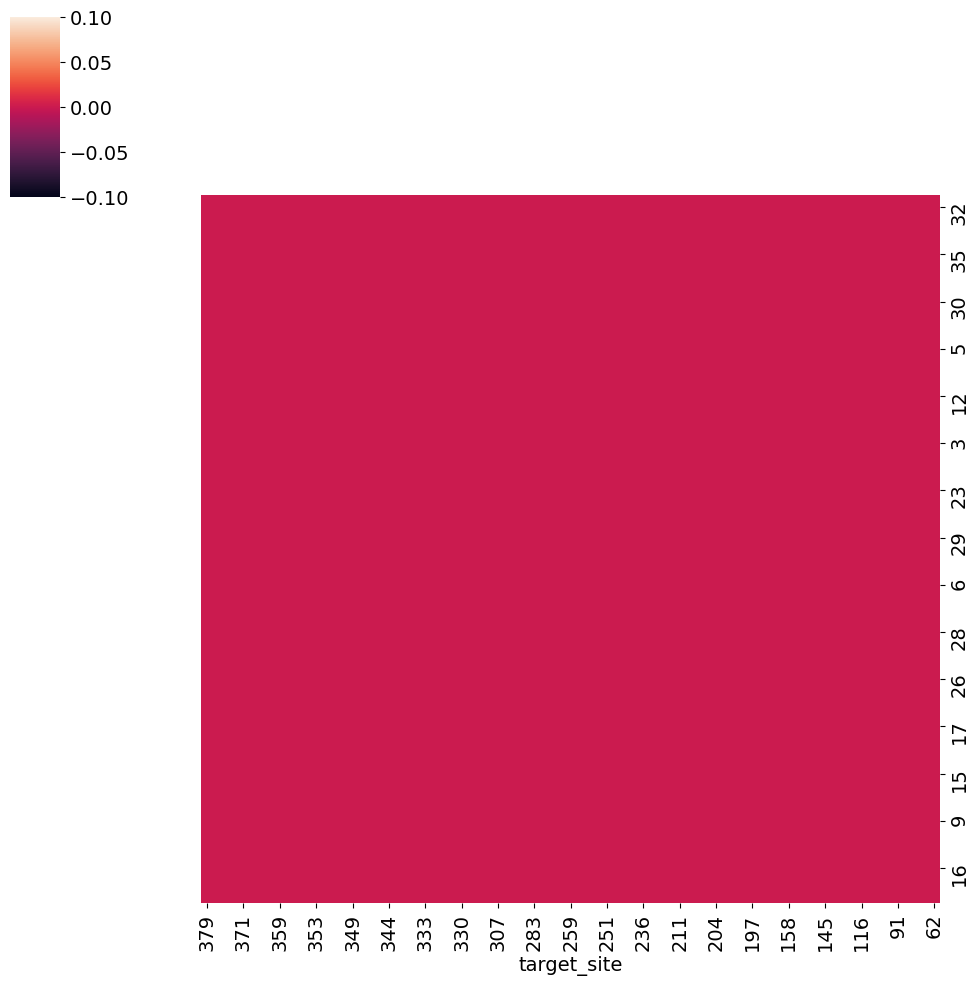

In [102]:
sns.clustermap(lp_ord.loc[:, sites_of_interest], col_cluster=False, row_cluster=False)

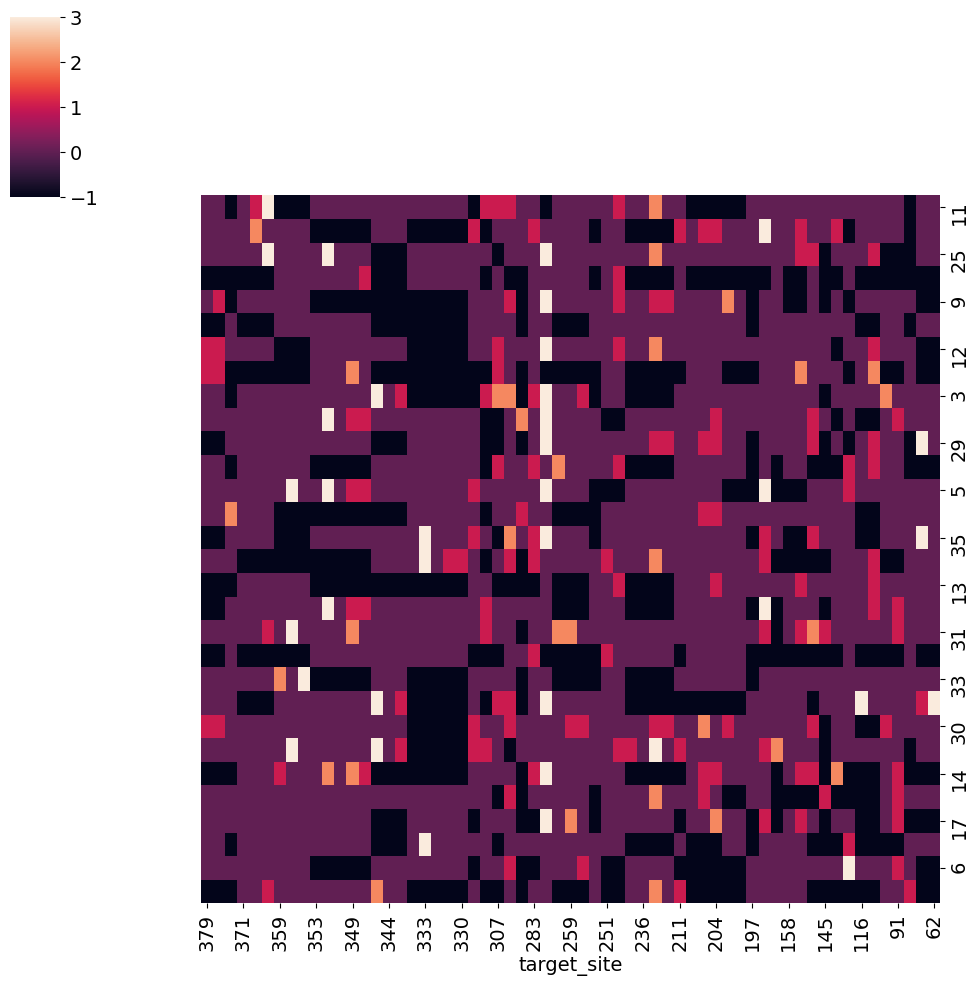

In [103]:
sns.clustermap(bm_ord.loc[:, sites_of_interest], col_cluster=False, row_cluster=False)

In [108]:
counts_wide = (
    bm_ord.loc[:, sites_of_interest]
          .apply(lambda s: s.value_counts(dropna=False))
          .fillna(0).astype(int)
)

In [112]:
counts_wide

target_site,379,378,374,371,368,367,359,357,356,353,...,145,133,127,116,115,92,91,68,65,62
-1.0,9,9,10,6,6,6,7,7,7,8,...,15,8,7,12,12,6,6,10,10,10
0.0,18,17,19,24,22,20,21,20,22,22,...,13,20,19,17,10,22,17,19,17,19
1.0,3,4,0,0,1,2,1,0,0,0,...,2,1,3,0,7,1,7,1,1,0
2.0,0,0,1,0,1,0,1,0,0,0,...,0,1,0,0,1,1,0,0,0,0
3.0,0,0,0,0,0,2,0,3,1,0,...,0,0,1,1,0,0,0,0,2,1


In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_stacked_state_counts(
    df, sites_of_interest,
    state_order=None,                 # e.g., ["missing", 0, 1, 2, 3]
    color_map=None,                   # dict like {state: "#color"}
    treat_minus1_as="missing",        # set to None to leave -1 as-is
    figsize=(12, 4), outfile=None
):
    # Subset & optional recode "-1" to a label like "missing"
    sub = df.loc[:, sites_of_interest].copy()
    if treat_minus1_as is not None:
        sub = sub.replace(-1, treat_minus1_as)

    # Long → counts
    counts_long = (
        sub.melt(var_name="site", value_name="state")
           .groupby(["site", "state"], dropna=False)
           .size().reset_index(name="count")
    )

    # Ensure site order follows sites_of_interest exactly
    counts_long["site"] = pd.Categorical(counts_long["site"],
                                         categories=sites_of_interest, ordered=True)

    # Decide state order (rows of pivot)
    if state_order is None:
        # default: sort by overall frequency (desc), then by state label
        total_per_state = counts_long.groupby("state")["count"].sum().sort_values(ascending=False)
        state_order = total_per_state.index.tolist()

    counts_long["state"] = pd.Categorical(counts_long["state"],
                                          categories=state_order, ordered=True)

    # Pivot to wide: rows=state, cols=site
    counts_wide = (counts_long
                   .pivot(index="state", columns="site", values="count")
                   .fillna(0).astype(int))

    # Build colors in the chosen state order
    if color_map is None:
        # fallback grayscale palette (top stack darkest)
        # feel free to swap in your palette here
        from matplotlib import cm
        cmap = cm.get_cmap("Greys", len(state_order) + 2)
        colors = [cmap(i + 2) for i in range(len(state_order))]
        colors = dict(zip(state_order, colors))
    else:
        colors = {s: color_map.get(s, "#808080") for s in state_order}

    # Plot stacked bars
    fig, ax = plt.subplots(figsize=figsize)
    bottom = np.zeros(len(sites_of_interest), dtype=float)

    for s in state_order:
        vals = counts_wide.loc[s, sites_of_interest].values if s in counts_wide.index else np.zeros_like(bottom)
        ax.bar(sites_of_interest, vals, bottom=bottom, label=str(s), color=colors[s], edgecolor="black", linewidth=0.4)
        bottom += vals

    ax.set_xlabel("Target site")
    ax.set_ylabel("Count over cells")
    # ax.set_title("Counts of each state per target site")
    ax.legend(title="State", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    ax.tick_params(axis="x", rotation=90)
    fig.tight_layout()

    if outfile:
        fig.savefig(outfile, bbox_inches="tight")
    return fig, ax, counts_wide  # return the table too for inspection

# Example usage:
# fig, ax, counts_table = plot_stacked_state_counts(bm_ord, sites_of_interest,
#                                                   state_order=["missing", 0, 1, 2, 3],
#                                                   outfile=f"{plotdir}/state_counts_stacked.pdf")


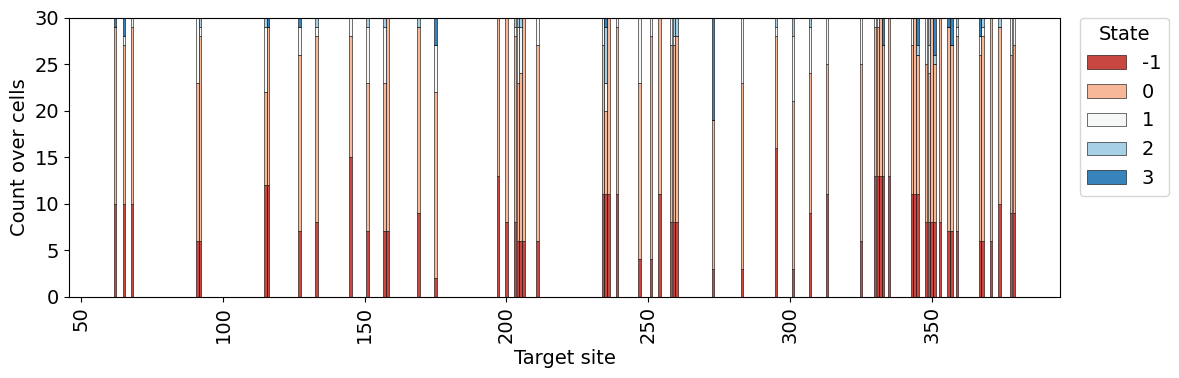

In [166]:
import matplotlib.pyplot as plt

states = [-1, 0, 1, 2, 3]
cmap   = plt.get_cmap("RdBu")

color_map = {s: cmap((i+1)/(len(states)+1))  # skip the very lightest
             for i, s in enumerate(states)}

fig, ax, counts_table = plot_stacked_state_counts(
    bm_ord, sites_of_interest,
    state_order=states,
    color_map=color_map,
    treat_minus1_as=None,   # keep -1 as a state, don't recode to "missing"
)

In [167]:
# # mask = merged['bM_geno'] != 0
# m_sub = merged.loc[mask].loc[merged["target_site"].isin(sites_of_interest)]
# m_sub

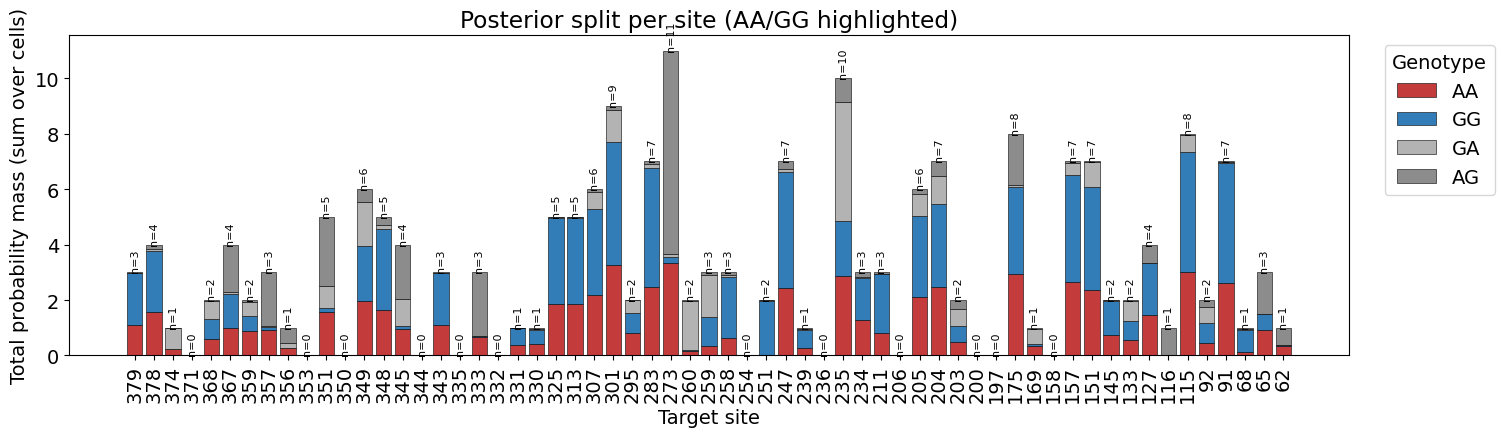

In [168]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

prob_cols = ["bMp_AA","bMp_GG","bMp_GA","bMp_AG"]
cmap = plt.get_cmap("RdBu")
colors = {
    "bMp_AA": cmap(0.15),   # blue-ish
    "bMp_GG": cmap(0.85),   # red-ish
    "bMp_GA": (0.70,0.70,0.70,1),
    "bMp_AG": (0.55,0.55,0.55,1),
}

# m_sub = merged.loc[merged["target_site"].isin(sites_of_interest)].copy()
# for c in ["target_site"] + prob_cols:
#     m_sub[c] = pd.to_numeric(m_sub[c], errors="coerce")

# total probability per site×state (sums over all cells)
long = m_sub.melt(id_vars=["target_site"], value_vars=prob_cols,
                  var_name="state", value_name="prob").dropna(subset=["prob"])
totals = (long.groupby(["target_site","state"], as_index=False)["prob"].sum())
totals["target_site"] = pd.Categorical(totals["target_site"],
                                       categories=sites_of_interest, ordered=True)
wide_tot = (totals.pivot(index="target_site", columns="state", values="prob")
                   .reindex(sites_of_interest).fillna(0))

# how many rows (cells) per site (for optional annotation)
n_cells = m_sub.groupby("target_site").size().reindex(sites_of_interest).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(max(10, 0.25*len(sites_of_interest)), 4.6))
bottom = np.zeros(len(wide_tot))
for state in ["bMp_AA","bMp_GG","bMp_GA","bMp_AG"]:
    vals = wide_tot[state].values if state in wide_tot.columns else np.zeros_like(bottom)
    ax.bar(wide_tot.index.astype(str), vals, bottom=bottom,
           label=state.replace("bMp_",""), color=colors[state],
           edgecolor="black", linewidth=0.4)
    bottom += vals

# Optional: annotate #cells above each bar
for xi, total, n in zip(range(len(bottom)), bottom, n_cells.values):
    ax.text(xi, total, f"n={n}", ha="center", va="bottom", fontsize=8, rotation=90)

ax.set_xlabel("Target site")
ax.set_ylabel("Total probability mass (sum over cells)")
ax.set_title("Posterior split per site (AA/GG highlighted)")
ax.legend(title="Genotype", bbox_to_anchor=(1.02,1), loc="upper left")
ax.tick_params(axis="x", rotation=90)
fig.tight_layout()


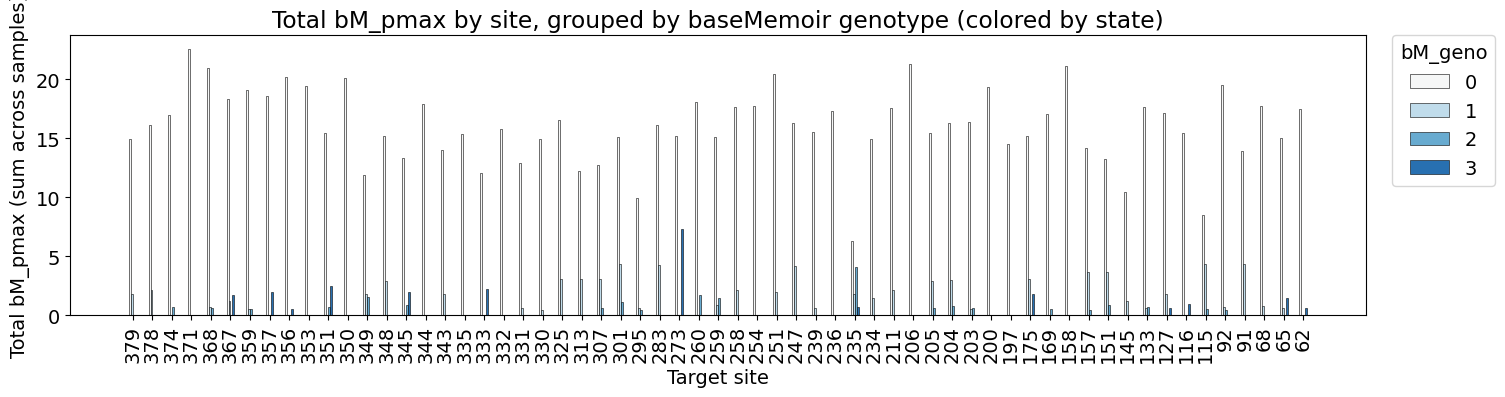

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- subset & ensure numeric ---
m_sub = merged.loc[merged["target_site"].isin(sites_of_interest)].copy()
m_sub["target_site"] = pd.to_numeric(m_sub["target_site"], errors="coerce")
m_sub["bM_geno"]     = pd.to_numeric(m_sub["bM_geno"], errors="coerce")
m_sub["bM_pmax"]     = pd.to_numeric(m_sub["bM_pmax"], errors="coerce")

# --- TOTAL probability (sum), not mean ---
tot_tbl = (
    m_sub.groupby(["target_site", "bM_geno"], dropna=False)["bM_pmax"]
         .sum(min_count=1)                 # sum; NaN if group all-NaN
         .reset_index()
)

# keep your x-axis order
tot_tbl["target_site"] = pd.Categorical(tot_tbl["target_site"],
                                        categories=sites_of_interest, ordered=True)
tot_tbl = tot_tbl.sort_values(["target_site", "bM_geno"])

# which states are present
present_states = tot_tbl["bM_geno"].dropna().unique().tolist()
present_states = sorted([s for s in present_states if s < 0]) \
                 + ([0] if 0 in present_states else []) \
                 + sorted([s for s in present_states if s > 0])

# diverging colors from RdBu centered at 0
cmap = plt.get_cmap("RdBu")
def diverging_colors(states, center=0):
    neg = [s for s in states if s < center]
    pos = [s for s in states if s > center]
    colors = {}
    for i, s in enumerate(sorted(neg)):
        t = 0.5 * (i + 1) / (len(neg) + 1) if len(neg) else 0.25
        colors[s] = cmap(t)
    if center in states:
        colors[center] = cmap(0.5)
    for i, s in enumerate(sorted(pos)):
        t = 0.5 + 0.5 * (i + 1) / (len(pos) + 1) if len(pos) else 0.75
        colors[s] = cmap(t)
    return colors

state_colors = diverging_colors(present_states, center=0)

# --- pivot for grouped bars (totals) ---
pivot = tot_tbl.pivot(index="target_site", columns="bM_geno", values="bM_pmax").reindex(sites_of_interest)

# --- plot grouped bars of TOTAL bM_pmax (weighted by sample count) ---
fig, ax = plt.subplots(figsize=(max(8, 0.25*len(sites_of_interest)), 4.2))
x = np.arange(len(pivot.index))
n = len(present_states)
width = min(0.8, 0.1*n) / max(n, 1)
offsets = (np.arange(n) - (n-1)/2) * width

for off, s in zip(offsets, present_states):
    vals = pivot.get(s)
    if vals is None:
        continue
    ax.bar(x + off, vals.values, width=width,
           label=str(int(s)) if float(s).is_integer() else str(s),
           color=state_colors[s], edgecolor="black", linewidth=0.4)

ax.set_xticks(x)
ax.set_xticklabels(pivot.index.astype(str), rotation=90)
ax.set_xlabel("Target site")
ax.set_ylabel("Total bM_pmax (sum across samples)")
ax.set_title("Total bM_pmax by site, grouped by baseMemoir genotype (colored by state)")
ax.legend(title="bM_geno", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
fig.tight_layout()
# fig.savefig(f"{plotdir}/total_bM_pmax_by_site_geno.pdf", bbox_inches="tight")


In [170]:
# Look at the probability of bMp_AA across this m_sub, group by target_site
(
    m_sub.groupby("target_site")["bMp_AA"]
    .describe(percentiles=[0.1, 0.5, 0.9])
)

,count,mean,std,min,10%,50%,90%,max
target_site,,,,,,,,
62,20.0,0.890069,0.159641,0.326149,0.805619,0.952448,0.989171,0.996316
65,20.0,0.797743,0.262169,0.191321,0.397596,0.967593,0.996699,0.998310
68,20.0,0.891943,0.190197,0.129341,0.818889,0.951812,0.987971,0.989893
91,24.0,0.687412,0.232553,0.371873,0.371873,0.772769,0.918566,0.965695
92,24.0,0.830174,0.205054,0.111395,0.733629,0.870853,0.956481,0.979596
...,...,...,...,...,...,...,...,...
368,24.0,0.898224,0.195816,0.283296,0.768422,0.979118,0.992168,0.997493
371,24.0,0.941408,0.115326,0.603349,0.802268,0.987441,0.996669,0.997534
374,20.0,0.861905,0.198301,0.226830,0.729606,0.952337,0.985987,0.994098


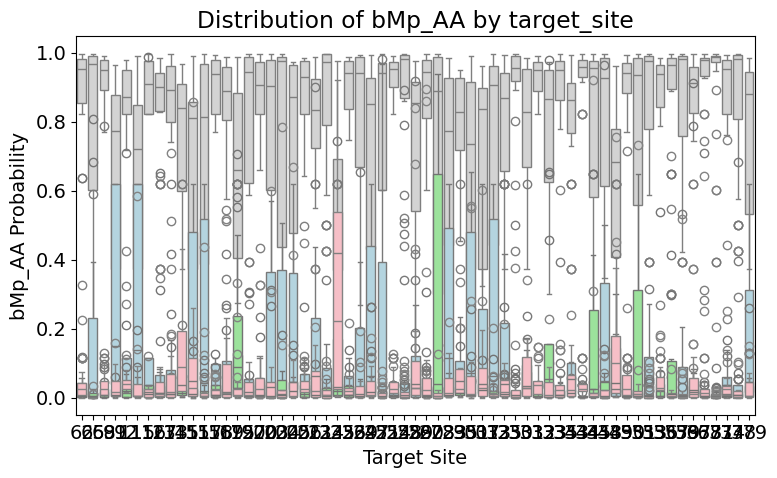

In [178]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=m_sub,
    x="target_site",
    y="bMp_AA",
    color="lightgray"
)

# plt.figure(figsize=(8, 5))
sns.boxplot(
    data=m_sub,
    x="target_site",
    y="bMp_GG",
    color="lightblue"
)
sns.boxplot(
    data=m_sub,
    x="target_site",
    y="bMp_AG",
    color="lightgreen"
)
sns.boxplot(
    data=m_sub,
    x="target_site",
    y="bMp_GA",
    color="lightpink"
)
# sns.stripplot(
#     data=m_sub,
#     x="target_site",
#     y="bMp_AA",
#     alpha=0.4,
#     color="black",
#     jitter=True
# )
plt.title("Distribution of bMp_AA by target_site")
plt.ylabel("bMp_AA Probability")
plt.xlabel("Target Site")
plt.tight_layout()
plt.show()

In [114]:
row_sums = counts_wide.sum(axis=1)
row_sums

-1.0     524
 0.0    1110
 1.0     129
 2.0      31
 3.0      36
dtype: int64

In [ ]:
# look at the baseMemoir probabilities for the baseMemoir genotypes, compared to the baseMemoir probabilities for the LAML-Pro genotypes here


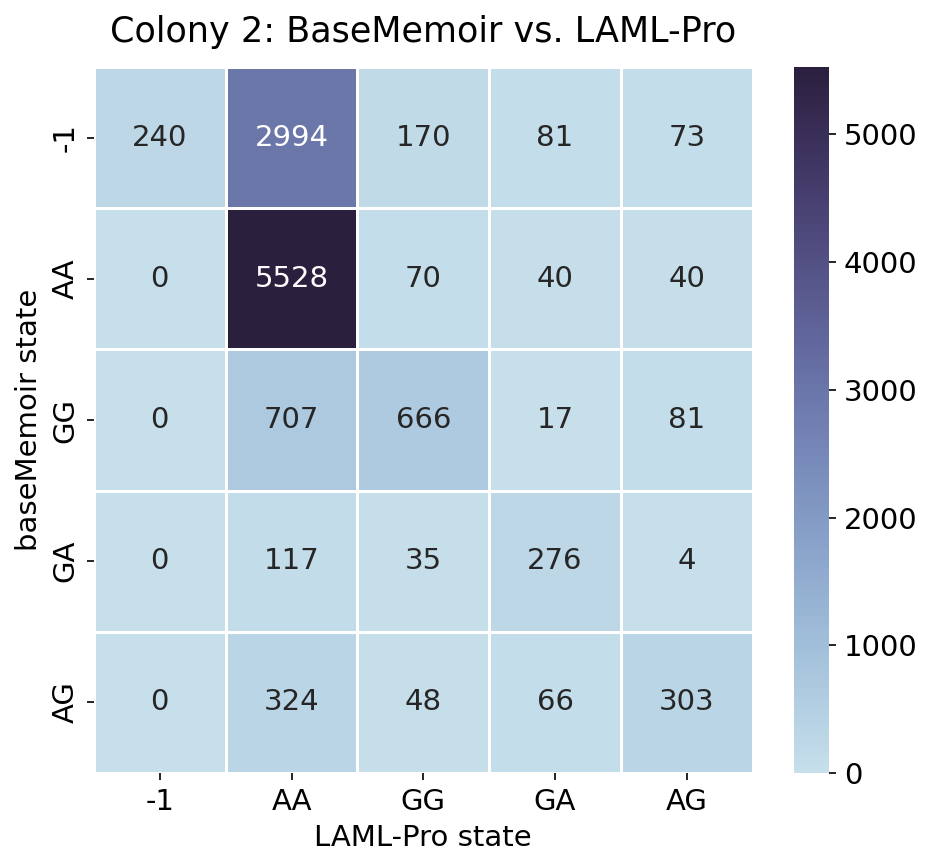

In [274]:
counts = plot_state_counts(bm_geno_df, lp_map_geno_df, title="Colony 2: BaseMemoir vs. LAML-Pro",
                          outfile=f"{plotdir}/colony2_genotype_counts.pdf")

In [275]:
counts

,-1,AA,GG,GA,AG
-1,240,2994,170,81,73
AA,0,5528,70,40,40
GG,0,707,666,17,81
GA,0,117,35,276,4
AG,0,324,48,66,303


In [276]:
counts_trim = (
    counts[counts.index != '-1']
    .drop(columns='-1'))
counts_trim

,AA,GG,GA,AG
AA,5528,70,40,40
GG,707,666,17,81
GA,117,35,276,4
AG,324,48,66,303


In [277]:
unedited = ['AA']            # baseMemoir (rows): AA = unedited
edited   = ['GG','GA','AG']  # GG/GA/AG = edited

uu = counts_trim.loc[unedited, unedited].to_numpy().sum()  # unedited → unedited
ue = counts_trim.loc[unedited, edited].to_numpy().sum()    # unedited → edited
eu = counts_trim.loc[edited, unedited].to_numpy().sum()    # edited → unedited
ee = counts_trim.loc[edited, edited].to_numpy().sum()      # edited → edited

summary_2x2 = pd.DataFrame(
    [[uu, ue],
     [eu, ee]],
    index=pd.Index(['Unedited','Edited'], name=''),
    columns=pd.Index(['Unedited','Edited'])
)

summary_2x2

,Unedited,Edited
,,
Unedited,5528,150
Edited,1148,1496


In [278]:
shared_sites = [c for c in bm_geno_df.columns if c in lp_map_geno_df.columns]

# Flatten both matrices into tidy long format
bm_long = bm_geno_df[shared_sites].stack().reset_index()
bm_long.columns = ["cell_name", "target_site", "bm_state"]

lp_long = lp_map_geno_df[shared_sites].stack().reset_index()
lp_long.columns = ["cell_name", "target_site", "lp_state"]

merged = (
    bm_input_geno_df.merge(bm_long, on=["cell_name", "target_site"])
                    .merge(lp_long, on=["cell_name", "target_site"])
)

Consider showing the normalized densities

In [21]:
colony = 2

In [57]:
merged

,cell_name,colony,site_idx,cassette_idx,target_site,bMp_AA,bMp_GG,bMp_GA,bMp_AG,bM_str_geno,bM_pmax,bM_geno,bm_state,lp_state
0,1,2,1,0,54,0.914841,0.014445,1.443476e-04,0.070570,AA,0.914841,0,0.0,0
1,1,2,2,0,55,0.452408,0.050180,1.713273e-01,0.326085,AA,0.452408,0,0.0,0
2,1,2,3,0,56,0.820160,0.141381,1.908135e-03,0.036551,AA,0.820160,0,0.0,0
3,1,2,4,0,57,0.894519,0.009735,1.979355e-02,0.075953,AA,0.894519,0,0.0,0
4,1,2,5,0,58,0.391229,0.324930,1.342881e-01,0.149553,AA,0.391229,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8317,9,2,2,0,49,0.989696,0.009622,5.572184e-07,0.000682,AA,0.989696,0,0.0,0
8318,9,2,3,0,50,0.954184,0.001021,4.446774e-02,0.000327,AA,0.954184,0,0.0,0
8319,9,2,4,0,51,0.940533,0.000170,2.087472e-06,0.059295,AA,0.940533,0,0.0,0
8320,9,2,5,0,52,0.997468,0.002507,2.424629e-06,0.000023,AA,0.997468,0,0.0,0


✅ Saved figure to: /Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_genotypecall_summary.pdf


/Users/gc3045/git/laml2-experiments/real_data/analysis/helpers/utils.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if clamp01:


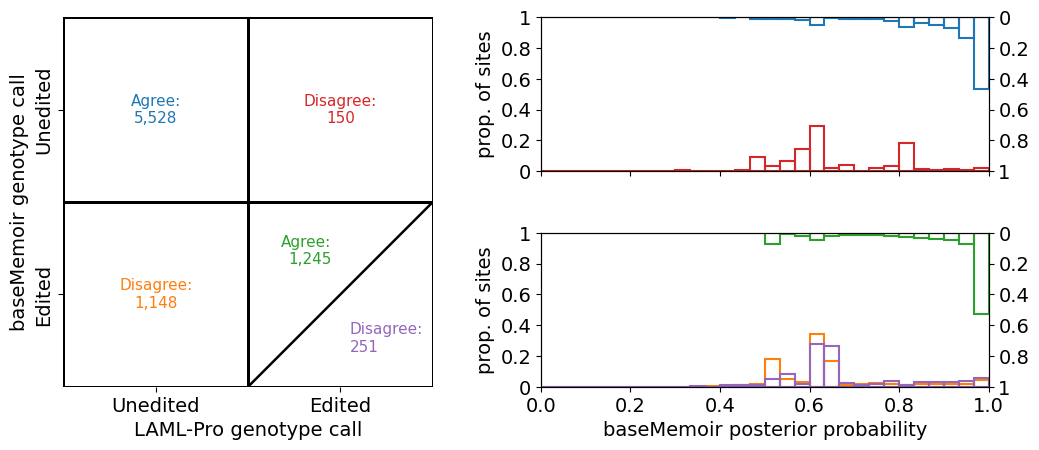

In [287]:
fig, ax = plot_genotypecall_summary(
    counts_trim, merged, y_max=1.0, outfile=f"{plotdir}/colony{colony}_genotypecall_summary.pdf"
)

In [ ]:
stats_df = report_genotype_call_stats(counts)
save_df_to_pdf(stats_df, filename=f"{plotdir}/colony2_genotype_call_stats.pdf", title=None, floatfmt="{:.4f}", fontsize=10)

#### Genotype concordance with tree topology

In [350]:
bm_distmat = distdict_to_df(bm_tree.distance_matrix(leaf_labels=True))
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))

In [351]:
bm_leaf_pairs = leaf_pairs(bm_distmat)
lp_leaf_pairs = leaf_pairs(lp_distmat)

In [352]:
bm_genodict = get_geno_dict(bm_input_geno_df)
hat = empirical_site_dists(bm_genodict)

In [353]:
bm_concordance = pair_metrics(bm_leaf_pairs, bm_genodict, hat)
lp_concordance = pair_metrics(lp_leaf_pairs, bm_genodict, hat)

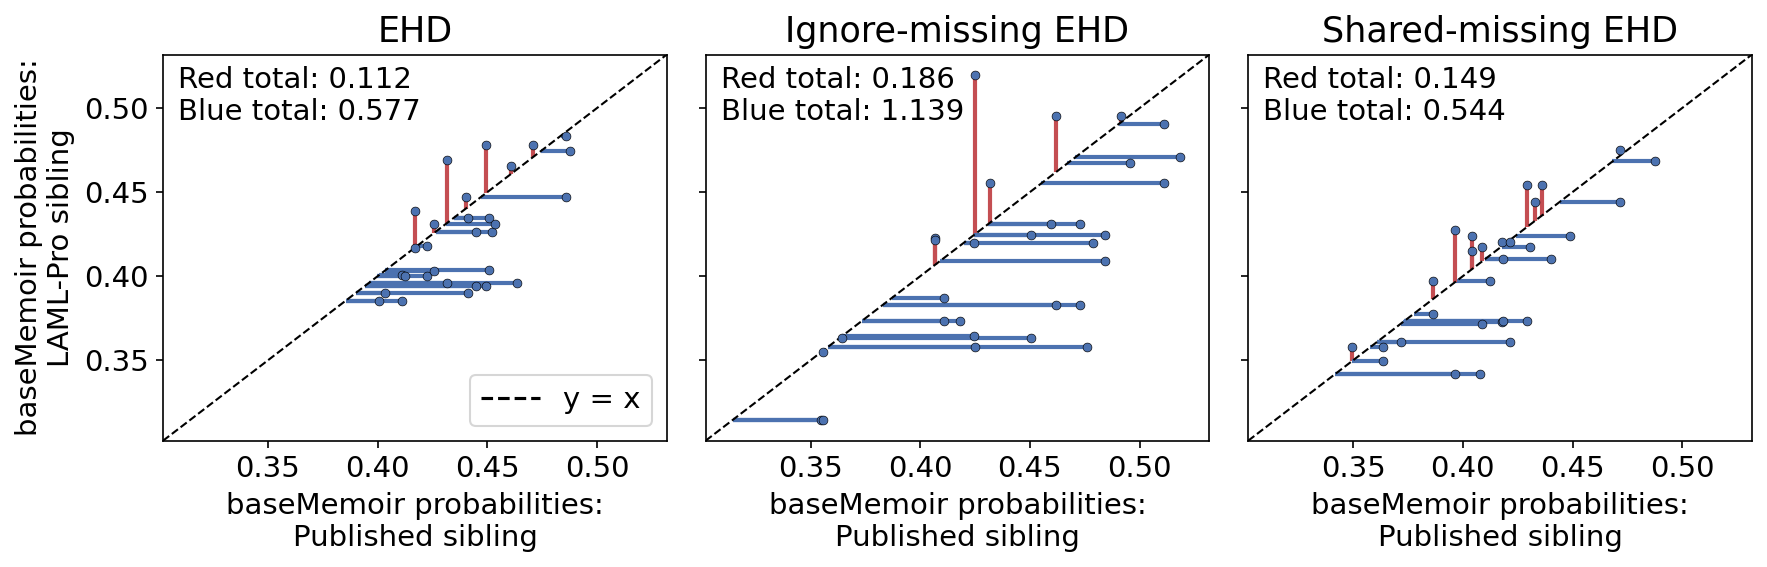

In [371]:
plot_concordance_scatterplot(bm_concordance, lp_concordance, 
                          outfile=f"{plotdir}/colony2_genotype_scatterplot.pdf")

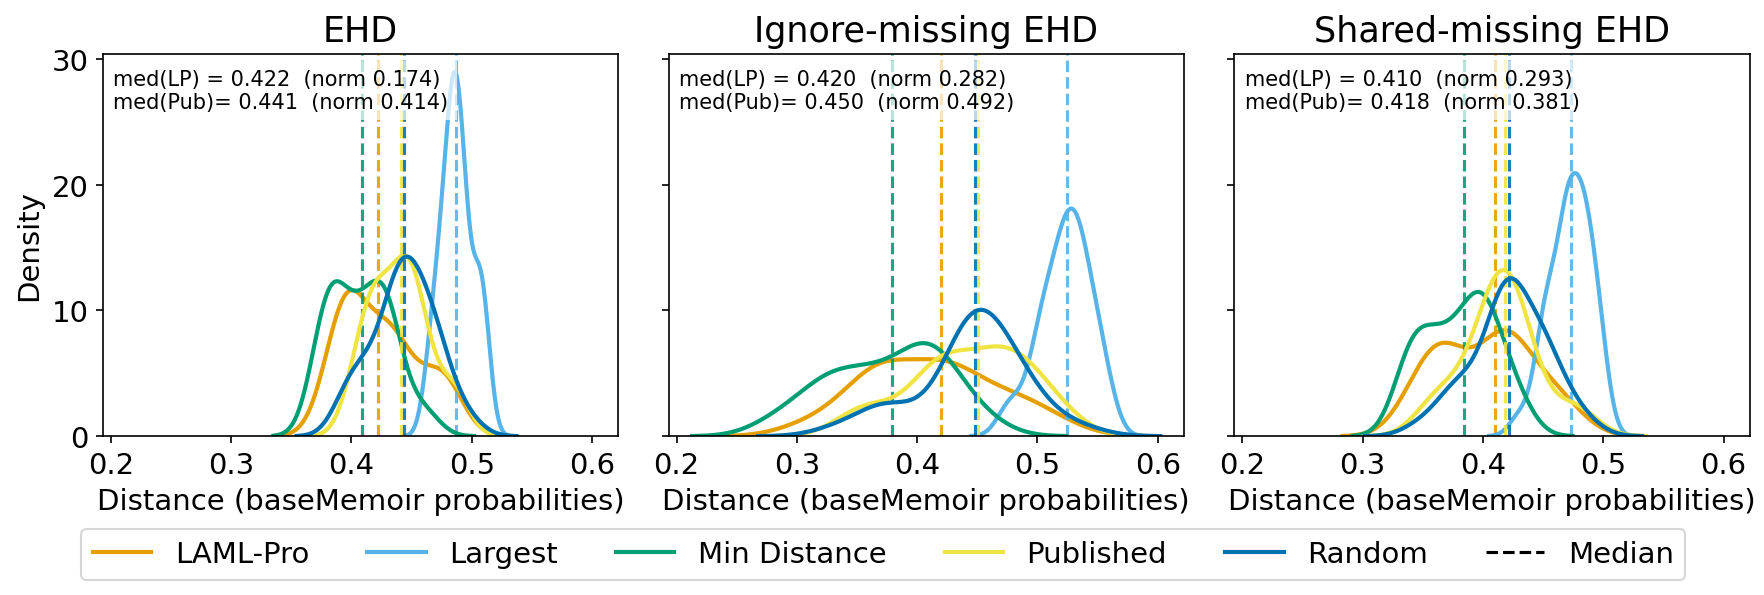

In [372]:
plot_concordance_distribution(bm_concordance, lp_concordance, bm_genodict, hat,
                          outfile=f"{plotdir}/colony2_genotype_distribution.pdf")

#### Spatial analysis

In [498]:
# scale trees

lp_tree.collapse_short_branches(0.0005)
lp_tree.root.set_edge_length(0.0)

tau = 72 # hours
bm_tree.scale_edges(tau/bm_tree.height())
lp_tree.scale_edges(tau/lp_tree.height())

var_x, var_y = centroids_df.var(axis=0)
print("Variance", var_x, var_y)
diffusion_scale = (var_x + var_y)/(2*tau)

bm_tree.scale_edges(diffusion_scale)
lp_tree.scale_edges(diffusion_scale)

add_internal_labels(bm_tree)
add_internal_labels(lp_tree)

print("Tree heights", bm_tree.height(), lp_tree.height())

Variance 106271.56624600854 185842.79625344044
Tree heights 146057.1812497245 146057.18124972453


In [499]:
bm_tree.write_tree_newick(bm_treefile[:-4] + ".scaled.newick")
lp_tree.write_tree_newick(lp_treefile[:-7] + ".scaled.newick")

#### Spatial visualization

In [7]:
lp_tree = treeswift.read_tree_newick(lp_treefile[:-7] + ".scaled.newick")
bm_tree = treeswift.read_tree_newick(bm_treefile[:-4] + ".scaled.newick")

In [8]:
bm_distmat = distdict_to_df(bm_tree.distance_matrix(leaf_labels=True))
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))

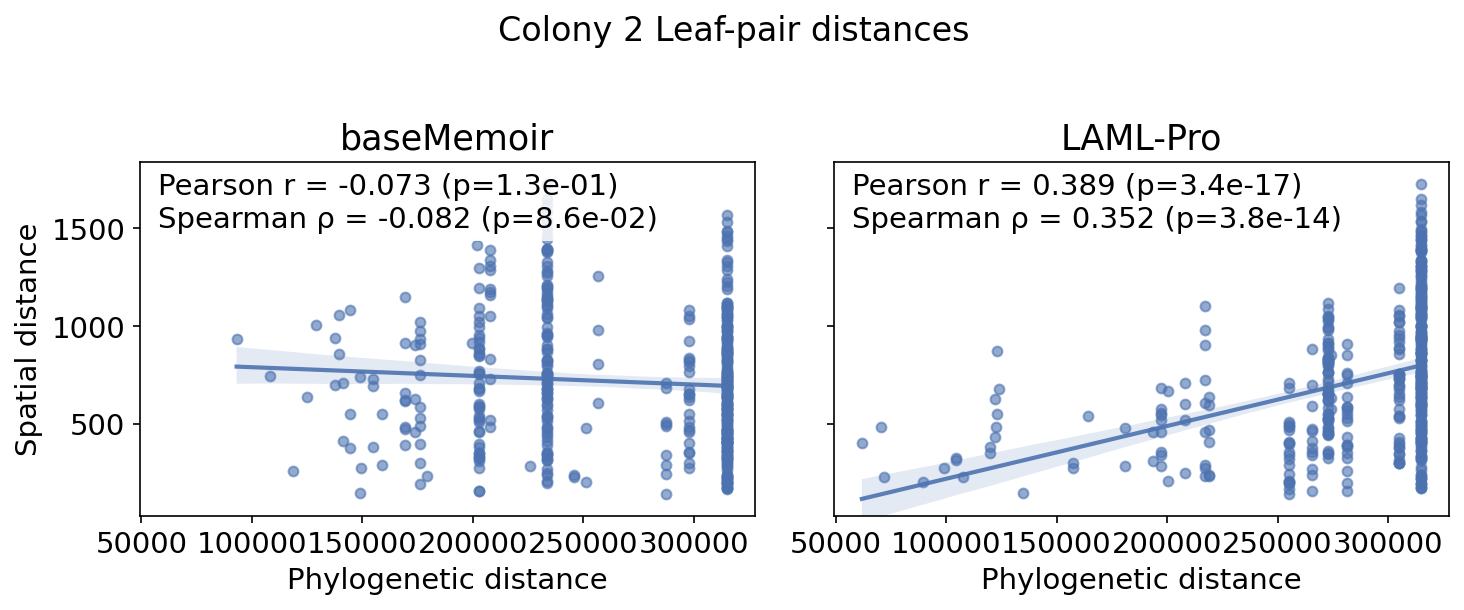

In [9]:
# plot phylogenetic distance against spatial distance and compute pearson correlation 
fig, axes = plot_correlation(centroids_df, bm_distmat, lp_distmat, title="Colony 2 Leaf-pair distances",
                outfile=f"{plotdir}/colony2_spatial_correlation.pdf")

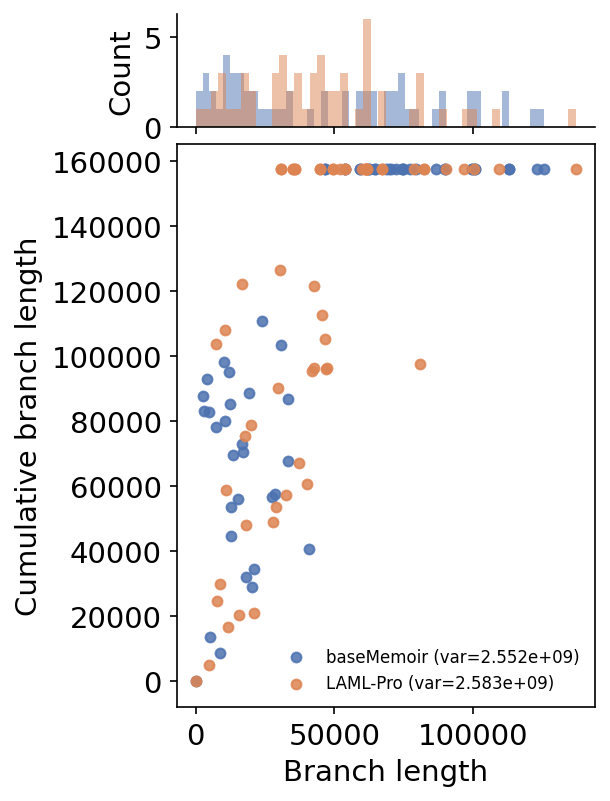

In [29]:
# generate the branch length vs. z (cumulative branch length) # annotate with histogram
bm_tree_df = branch_table(bm_tree)
lp_tree_df = branch_table(lp_tree)

fig = plot_bl_variance(bm_tree_df, lp_tree_df, title=None, 
                 outfile=f"{plotdir}/colony2_branchlen_variance.pdf")

#### 3D interactive plot

In [112]:
# generate the 3D interactive plot

lp_tree = treeswift.read_tree_newick(lp_treefile)
bm_tree = treeswift.read_tree_newick(bm_treefile)

lp_tree.collapse_short_branches(0.0005)
lp_tree.root.set_edge_length(0.0)

tau = 72 # hours
bm_tree.scale_edges(tau/bm_tree.height())
lp_tree.scale_edges(tau/lp_tree.height())

analysis_basename = "/Users/gc3045/git/laml2-experiments/real_data/analysis/"
colony = 2

centroids_df.columns = ["X", "Y"]
ancestral_labeling_df = pd.read_csv(f"{analysis_basename}/colony{colony}_bm_ancestral_labeling.txt", index_col=0)
ancestral_labeling_df.columns = centroids_df.columns
bm_merged_df = pd.concat([ancestral_labeling_df, centroids_df], axis=0)

centroids_df.columns = ["X", "Y"]
ancestral_labeling_df = pd.read_csv(f"{analysis_basename}/colony{colony}_lp_ancestral_labeling.txt", index_col=0)
ancestral_labeling_df.columns = centroids_df.columns
lp_merged_df = pd.concat([ancestral_labeling_df, centroids_df], axis=0)

In [117]:
fig = plot_tree_3d(lp_tree, lp_merged_df, x_col="X", y_col="Y",
                   title="LAML-Pro: Cells in 3D",
                   outfile=f"{plotdir}/colony{colony}_lamlpro_tree.html")

Saved interactive HTML to: /Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_lamlpro_tree.html


In [118]:
fig = plot_tree_3d(bm_tree, bm_merged_df, x_col="X", y_col="Y",
                   title="baseMemoir: Cells in 3D",
                   outfile=f"{plotdir}/colony{colony}_baseMemoir_tree.html")

Saved interactive HTML to: /Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_baseMemoir_tree.html


#### Try visualizing the published inferred spatial annotations

Tried visualizing the published baseMemoir inferred spatial annotations, but we don't have a direct comparison since the baseMemoir annotations seem to be in different units (not pixels). 

In [103]:
# # extract baseMemoir published spatial annotations
# import re

# colony = 2
# fname = f"/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.pos{colony}.full.newick"
# df_xy_all = extract_locations_df_from_file(fname, include_unlabeled_internals=True)
# df_xy_all = df_xy_all.set_index('cell')

In [104]:
# df_xy_all

In [105]:
# bm_merged_df

In [106]:
# df_xy = df_xy_all
# df = df_xy.copy()
# columns=("x","y")
# leaves=None

# # ensure 'cell' is the index
# if 'cell' in df.columns:
#     df = df.drop_duplicates('cell').set_index('cell')
# df.index = df.index.map(str)

# # keep only requested columns, drop rows with NaNs
# cols = list(columns)
# df = df[cols].dropna(how="any")

# # filter to leaves: either by explicit list or by removing "internal_*"
# if leaves is not None:
#     keep = {str(x) for x in leaves}
#     df = df.loc[df.index.isin(keep)]
# else:
#     df = df[~df.index.str.startswith("internal_")]

#     # convert to dict -> np.array
# bm_xy_dict = {k: df.loc[k, cols].to_numpy(dtype=float) for k in df.index}

In [107]:
# from ete3 import Tree

# fname = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.colony2.published.nwk"
# tree = Tree(fname, format=1)

In [108]:
# def tree_height(t):
#     """Return max root→leaf distance (tree 'height') using branch lengths."""
#     _leaf, dist = t.get_farthest_leaf()
#     return float(dist)

# def scale_tree_to_height(t, target_height=72.0, in_place=True):
#     """
#     Scale all edges so the tree's height equals target_height.
#     Returns (old_height, scale_factor, new_height).
#     """
#     # If you prefer not to mutate the original tree, copy it:
#     tree = t if in_place else t.copy()

#     old_h = tree_height(tree)
#     if old_h <= 0:
#         raise ValueError("Cannot scale a zero-height tree (max root→leaf distance is 0).")

#     s = target_height / old_h

#     # Multiply every branch length (dist) by s
#     for n in tree.traverse("preorder"):
#         # n.dist is length to parent; root.dist is typically 0
#         if getattr(n, "dist", None) is None:
#             n.dist = 0.0
#         else:
#             n.dist *= s

#     new_h = tree_height(tree)
#     return (old_h, s, new_h, tree)

In [109]:
# print("Current height:", tree_height(tree))

# old_h, scale, new_h, _ = scale_tree_to_height(tree, target_height=72.0, in_place=True)
# print(f"Scaled by {scale:.6g}: {old_h:.6g} → {new_h:.6g}")

# # Quick sanity check:
# assert abs(tree_height(tree) - 72.0) < 1e-6

In [110]:
# model = es.Square_Parsimony(tree, bm_xy_dict)

In [111]:
# fig = plot_tree_3d(bm_tree, df_xy_all, x_col="x", y_col="y",
#                    title="baseMemoir (published): Cells in 3D")

#### Other metrics

In [528]:
N, K = lp_map_geno_df.loc[[n for n in lp_map_geno_df.index if not n.startswith('internal')],].shape

In [529]:
np.sum(bm_input_geno_df['bM_pmax'] > 0.70) / (N * 396)

np.float64(0.5156565656565657)

In [42]:
ratios_df = edge_ratio_table(lp_tree, lp_merged_df, x_col="X", y_col="Y")
print(ratios_df[["node_label","parent_label","edge_length","xy_distance_to_parent","bl_over_xy"]].head())
print(ratios_df[["edge_length","xy_distance_to_parent","bl_over_xy"]].mean(axis=0))

  node_label parent_label  edge_length  xy_distance_to_parent  bl_over_xy
0         23  internal_52    14.146489             199.247997    0.070999
1          8  internal_56    20.478394             100.494118    0.203777
2          3  internal_34    24.585762             113.645649    0.216337
3          1  internal_34    24.585762             113.645649    0.216337
4         31  internal_52    14.146489             199.247997    0.070999
edge_length               21.170365
xy_distance_to_parent    202.391990
bl_over_xy                 0.123217
dtype: float64


In [43]:
ratios_df = edge_ratio_table(bm_tree, bm_merged_df, x_col="X", y_col="Y")
print(ratios_df[["node_label","parent_label","edge_length","xy_distance_to_parent","bl_over_xy"]].head())
print(ratios_df[["edge_length","xy_distance_to_parent","bl_over_xy"]].mean(axis=0))

  node_label parent_label  edge_length  xy_distance_to_parent  bl_over_xy
0         14                 35.328497             394.350458    0.089587
1          5                 27.078871             128.604980    0.210558
2         18                 28.552848             318.881445    0.089541
3         34                 31.434787             438.995194    0.071606
4          9                 29.501543             501.818233    0.058789
edge_length               22.400454
xy_distance_to_parent    263.288483
bl_over_xy                 0.111794
dtype: float64


In [46]:
def _split_kvlist(s: str):
    """Split top-level comma-separated k=v items, ignoring commas inside {...}."""
    parts, buf, depth = [], [], 0
    for ch in s:
        if ch == '{': depth += 1
        elif ch == '}': depth -= 1
        if ch == ',' and depth == 0:
            parts.append(''.join(buf).strip()); buf = []
        else:
            buf.append(ch)
    if buf: parts.append(''.join(buf).strip())
    return parts

def _parse_pair(val: str):
    """Parse '{x,y}' -> (float(x), float(y)) or return None."""
    val = val.strip()
    m = re.match(r'^\{(.*)\}$', val, flags=re.DOTALL)
    if not m:
        return None
    parts = _split_kvlist(m.group(1).strip())
    if len(parts) < 2:
        return None
    try:
        return float(parts[0]), float(parts[1])
    except ValueError:
        return None

def load_newick_from_file(path: str) -> str:
    """Return the first Newick tree found in the file (works for plain .nwk or Nexus)."""
    with open(path, 'r') as f:
        txt = f.read()
    # Try Nexus-style: 'tree XYZ = ( ... );'
    m = re.search(r'=\s*(\(.+?;)', txt, flags=re.DOTALL)
    if m:
        return m.group(1).strip()
    # Fallback: first '( ... );' blob
    m = re.search(r'(\(.+?;)', txt, flags=re.DOTALL)
    if m:
        return m.group(1).strip()
    # Last resort: return raw text
    return txt.strip()

def extract_locations_df_from_file(path: str, include_unlabeled_internals=True) -> pd.DataFrame:
    newick_str = load_newick_from_file(path)
    rows = []
    internal_counter = 0

    # Find all annotation blobs like [&k=v,...] across newlines
    for m in re.finditer(r'\[\&(.*?)\]', newick_str, flags=re.DOTALL):
        kv_blob = m.group(1)

        # Token (node label) immediately before '['; stop at separators '(),:'
        j = m.start() - 1
        while j >= 0 and newick_str[j].isspace():
            j -= 1
        token_end = j
        while j >= 0 and newick_str[j] not in '(),:':
            j -= 1
        token = newick_str[j+1:token_end+1].strip()

        if token:
            node_name = token
        else:
            if not include_unlabeled_internals:
                continue
            internal_counter += 1
            node_name = f"internal_{internal_counter}"

        # Parse k=v pairs
        kv = {}
        for entry in _split_kvlist(kv_blob):
            if '=' in entry:
                k, v = entry.split('=', 1)
                kv[k.strip()] = v.strip()

        # Prefer pair in {x,y}
        xy = None
        if 'locationsp2_locations' in kv:
            xy = _parse_pair(kv['locationsp2_locations'])

        # Fallback to scalar components
        if xy is None:
            v1 = kv.get('locationsp2_locations1')
            v2 = kv.get('locationsp2_locations2')
            if v1 is not None and v2 is not None:
                try:
                    xy = (float(v1), float(v2))
                except ValueError:
                    xy = None

        if xy is not None:
            rows.append({'cell': node_name, 'x': xy[0], 'y': xy[1]})

    return pd.DataFrame(rows, columns=['cell', 'x', 'y'])